<a href="https://colab.research.google.com/github/startluv/machine_learning/blob/main/2021320081_%EC%9D%B4%EC%8A%B9%EC%97%BD_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 데이터 선정


1.   해결하고자 하는 문제

  마케팅 관련된 데이터로 올바른 소비자 집단을 타겟하거나, 마케팅 전략을 수립하는데 도움을 주는 모델을 만들고자 한다.
2.  데이터셋 탐색

 은행 마케팅에 따른 고객 가입 여부를 판단하는 classification model을 구축하는 데이터셋을 활용하여 기계학습 모델링을 진행하고자 한다.
3.  데이터 설명 및 출처

  출처 : https://archive.ics.uci.edu/dataset/222/bank+marketing

  설명 : 이 데이터는 포르투갈 은행 기관의 직접 마케팅 캠페인(전화 통화)과 관련이 있다. 분류 목표는 고객이 정기예금(변수 y)에 가입할지 여부를 예측하는 것이다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
# 데이터 로드

# ;를 구분자로 사용하고, "를 따옴표로 처리
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bank-full.csv", sep=';', quotechar='"')

# 데이터 확인
print(data.head())
print(data.info())



   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #

In [ ]:
print(data['y'].value_counts())  # 타겟 변수의 분포 확인


y
no     39922
yes     5289
Name: count, dtype: int64


#2. 문제 설정 및 전체적인 과제 설계

1. 해당 문제에서의 목표

  yes를 잘 예측할 수 있는 모델을 구성하는 것을 목표로 한다.

  문제의 예측 비용을 따져 보았을 때, 예금 가입에 대해 no인 사람을 yes로 예측하는 리스크보다, yes인 사람을 no로 예측하는 리스크가 더욱 크다. 즉 yes를 감지하지 못하는 risk가 더욱 크며, 데이터 또한 no와 yes의 비율이 8:1로 yes가 상당히 적은 케이스임을 알 수 있다. 그렇기 때문에 yes를 잘 예측할 수 있는 모델을 구성하는 것을 목표로 한다.
2. 아래 출처의 논문*에 따르면,

> 텔레마케팅을 수행했을 때 상품판매
에 성공한 고객의 수는 실패한 고객의 수보다 적을
수밖에 없기 때문에 축적된 데이터는 성공한 고객의
수와 실패 고객의 수가 불균형을 이루는 구조이다.
따라서 혼성 표본 추출(Hybrid Sampling)에 의한 데
이터 균형화를 통하여 성공한 고객의 수와 실패한 고
객의 수에 대한 균형 잡힌 데이터를 생성한다

*이현진, ⌈혼성 표본 추출과 적층 딥 네트워크에 기반한 은행 텔레마케팅 고객 예측 방법⌋,디지털산업정보학회 논문지 제15권 제3호-2019년 9월, 2쪽


3. 문제 정의
   
   이 문제는 class가 정해져있는 지도학습이며, 분류 문제에 해당한다.

4. 모델의 성능 측정 지표
  불균형 데이터 셋이므로, accuracy보다는 sensitivity와, recall, precison을 결합한 f1-score 및 roc-auc로 성능을 판단하는 것이 좋다.
 * sensitivity의 경우는 문제 정의와 더불어 실제 yes class를 yes로 예측하는 것이 중요하기 때문이다.
 * f1-score는 precision과 recall의 평균을 계산한 값으로, 양성 클래스에 집중하여 평가할 때 적합하며, 불균형 클래스에 대해서 평가할 때도 적합하다.
 * ROC-AUC는 TPR과 FPR의 관계를 시각화하고, 이 곡선의 면적을 통해 모델의 분류 성능을 평가한다.
 전반적인 모델의 성능을 평가하고자 할 때 적합하다.

 5. YES에 대해 최소 80%의 성능을 보장해야 한다고 판단된다. 클래스 비율이 8:1이기 때문에, YES를 예측하는 것이 다소 힘들것이라 판단되기 때문이다.



#3. 데이터 탐색 및 분석 (EDA)


In [ ]:
from sklearn.model_selection import train_test_split
""" 처음 클래스 불균형을 해소하지 않은 코드
# 'y'가 'yes'와 'no'의 클래스 레이블을 포함한 열이라 가정
X = data.drop('y', axis=1)  # 특성(features) 데이터
y = data['y']  # 타겟 변수(target)

# 층화 샘플링을 통해 33% 샘플링
X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=0.33, stratify=y, random_state=42)

# 결과 확인
print(f"샘플링 후 데이터 크기: {X_sampled.shape}")
print(f"샘플링 후 타겟 분포:\n{y_sampled.value_counts()}")"""


from sklearn.utils import resample
import pandas as pd

# 특성(features) 데이터와 타겟 변수(target)
X = data.drop('y', axis=1)  # 특성(features)
y = data['y']  # 타겟 변수(target)

# 데이터프레임 형태로 병합
df = pd.concat([X, y], axis=1)

# 'yes'와 'no'로 데이터 분리
df_yes = df[df['y'] == 'yes']  # 소수 클래스
df_no = df[df['y'] == 'no']  # 다수 클래스

# 소수 클래스(yes)를 오버샘플링
df_yes_oversampled = resample(
    df_yes,
    replace=True,                # 복원 샘플링
    n_samples=len(df_no),        # 다수 클래스와 같은 크기로 샘플링
    random_state=42              # 재현성을 위한 랜덤 시드
)

# 다수 클래스(no)를 랜덤 언더샘플링 (원래 크기를 유지하려면 이 단계는 생략 가능)
df_no_downsampled = resample(
    df_no,
    replace=False,               # 비복원 샘플링
    n_samples=len(df_yes_oversampled),  # 소수 클래스와 같은 크기로 샘플링
    random_state=42              # 재현성을 위한 랜덤 시드
)

# 오버샘플링된 yes와 다운샘플링된 no를 결합
df_balanced = pd.concat([df_yes_oversampled, df_no_downsampled])

# 섞기(shuffle)
df_balanced = df_balanced.sample(frac=0.3, random_state=42).reset_index(drop=True)


# X와 y로 분리
X_sampled = df_balanced.drop('y', axis=1)
y_sampled= df_balanced['y']




# 결과 확인
print(f"균형 맞춘 데이터 크기: {X_sampled.shape}")
print(f"균형 맞춘 타겟 분포:\n{y_sampled.value_counts()}")




균형 맞춘 데이터 크기: (23953, 16)
균형 맞춘 타겟 분포:
y
no     11986
yes    11967
Name: count, dtype: int64


#데이터 전처리 - <숫자형 int 특성 처리>

1. age: 나이 범위에 따라 그룹화할 수 있다. 예를 들어, 나이를 20대, 30대, 40대 등으로 분류하여 그룹화를 시도한다.

2. balance: 음수값이 있는 경우, 이는 "부채" 또는 "부정적 잉여금"을 나타낼 수 있다. 음수를 처리하는 방법을 고민할 필요가 있다. 예를 들어, balance가 음수인 데이터를 0으로 처리하거나 log 변환을 사용할 수 있다.

3. duration, campaign, pdays, previous: 시간 기반 특성으로, 이러한 변수들은 크게 차이가 나는 값들을 포함할 수 있기 때문에, 스케일링을 하는 것이 좋다. 예를 들어, StandardScaler나 MinMaxScaler를 사용할 수 있습니다.


int형 변수를 시각화하고, 데이터 전처리 방법을 모색한다.

   pdays
0     -1
1     -1
2     -1
3     -1
4     -1


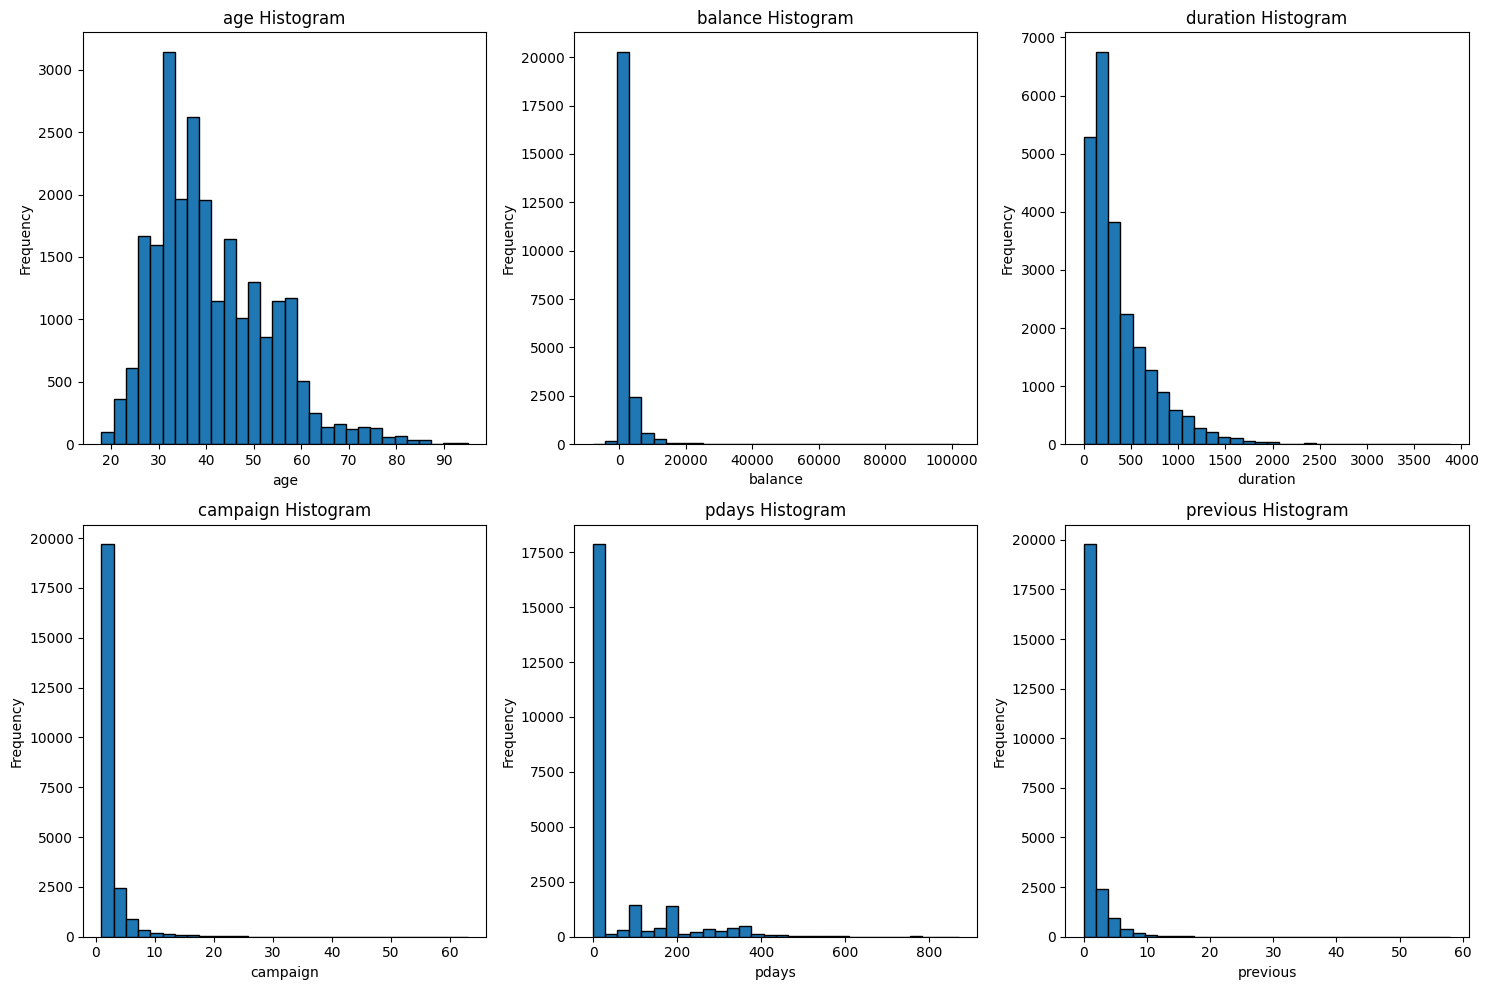

In [ ]:
import matplotlib.pyplot as plt

# int 특성 리스트
int_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

print(X_sampled[['pdays']].head())

# 히스토그램을 각 특성에 대해 출력
plt.figure(figsize=(15, 10))
for i, feature in enumerate(int_features, 1):
    plt.subplot(2, 3, i)
    plt.hist(X_sampled[feature], bins=30, edgecolor='black')
    plt.title(f'{feature} Histogram')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


count    23953.000000
mean        52.446917
std        109.707040
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         60.000000
max        871.000000
Name: pdays, dtype: float64
음수 값의 개수: 17736


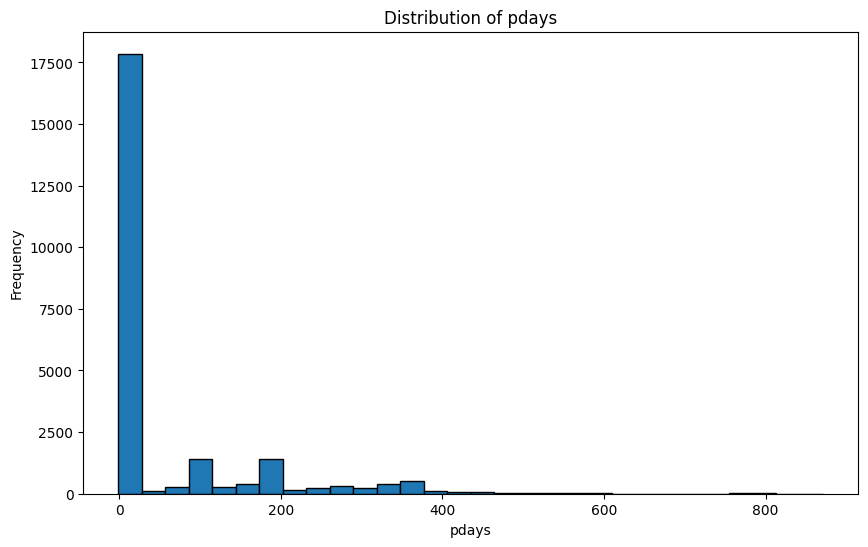

pdays
-1      36954
 1         15
 2         37
 3          1
 4          2
        ...  
 838        1
 842        1
 850        1
 854        1
 871        1
Name: count, Length: 559, dtype: int64


In [ ]:
# pdays 특성의 기본 통계 확인
print(X_sampled['pdays'].describe())

# pdays 특성에서 음수 값의 개수 확인
negative_pdays = X_sampled[X_sampled['pdays'] < 0]
print(f'음수 값의 개수: {len(negative_pdays)}')

# pdays 값의 분포를 시각적으로 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(X_sampled['pdays'], bins=30, edgecolor='black')
plt.title('Distribution of pdays')
plt.xlabel('pdays')
plt.ylabel('Frequency')
plt.show()

# pdays 특성에서 값의 개수별로 분포 확인 (음수와 0도 포함)
print(data['pdays'].value_counts().sort_index())


age의 분포는 비교적 고르게 나타난 편이지만, 그 외의 그래프는 상당히 편향되어있음을 알 수 있다. 이에 대해 다양한 변환을 시도할 수 있다.
예를들어 로그변환, 제곱근 변환, Z-점수 표준화 등이 있다. 그 중 로그변환과 z-점수 표준화를 시도해보고 다시 histogram을 확인해보았다.

pdays의 경우


```
count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
```

이렇게 분포가 되어있는데,  대부분이 -1이며 feature 설명에 의하면, 이전에 전화를 받지 않은 고객이므로, 이를 바탕으로 새로운 binary feature를 생성가능하다. (이전에 전화를 받은 고객과 그렇지 않은 고객 그리고 -1~800으로 값의 scale이 상당하므로 이 feature를 그냥 binary로 변환할 지, 몇 이상이면 2, 1, 0 이렇게 범주형으로 할 지도 생각해보아야 할 듯 하다.)


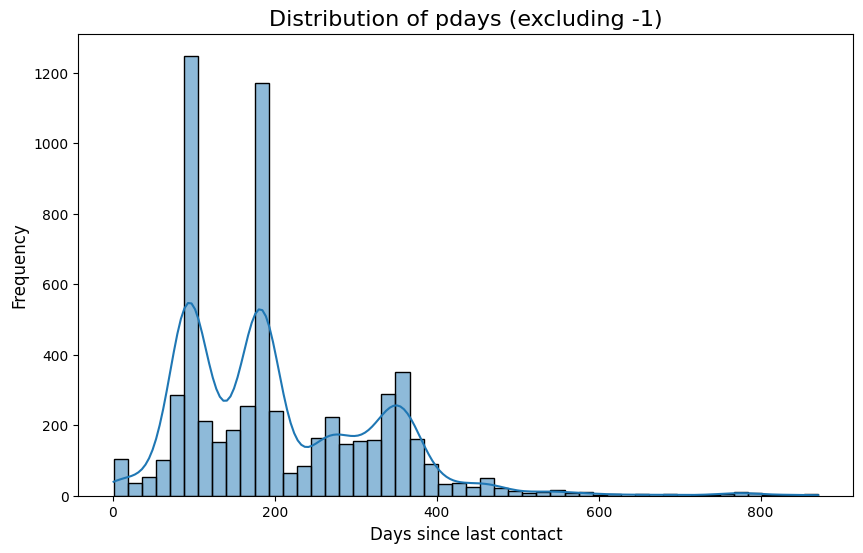

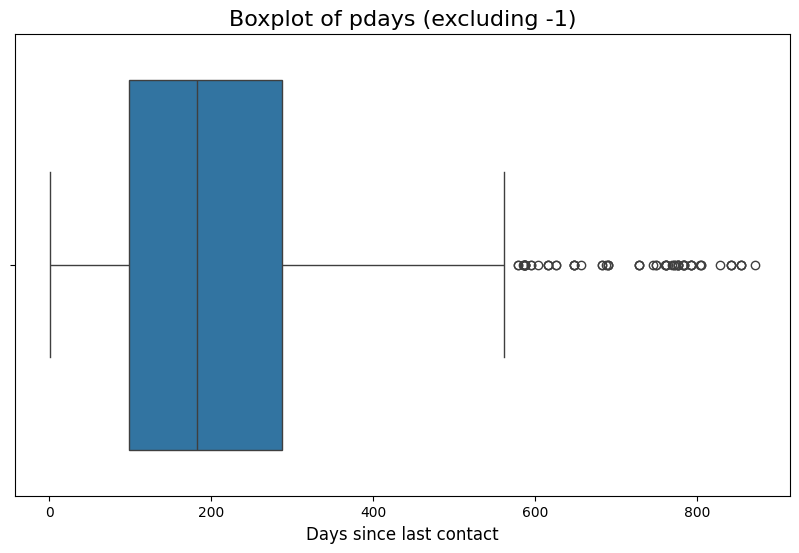

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# pdays가 -1인 값을 제외한 데이터만 필터링
pdays_filtered = X_sampled[X_sampled['pdays'] != -1]['pdays']

# 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(pdays_filtered, kde=True, bins=50)
plt.title('Distribution of pdays (excluding -1)', fontsize=16)
plt.xlabel('Days since last contact', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 박스플롯
plt.figure(figsize=(10, 6))
sns.boxplot(x=pdays_filtered)
plt.title('Boxplot of pdays (excluding -1)', fontsize=16)
plt.xlabel('Days since last contact', fontsize=12)
plt.show()


pdays의 -1을 제외한 분포를 보면 다봉분포 형식을 띄는 것을 확인할 수 있다.
이에 따라 pdays는 binning 하는 것이 더 유용할 수 있음을 생각할 수 있다.
이에, RBF-KERNERL을 활용해 변환을 시도하였으나 의미있는 결과를 얻지는 못했다.


In [ ]:
"""import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
X_sampled['pdays'] = X_sampled['pdays'].replace(-1, 0)

# RBF 변환 함수 정의
def rbf_transform(X):
    # 기본적인 RBF 변환을 위한 커널 함수 사용
    return rbf_kernel(X, X)

# FunctionTransformer 사용하여 RBF 변환 적용
transformer = FunctionTransformer(rbf_transform, validate=True)

# pdays 데이터를 변환하여 RBF 적용
rbf_transformed = transformer.fit_transform(data[['pdays']])

# 변환된 데이터 확인
X_sampled['pdays_rbf'] = rbf_transformed[:, 0]  # 첫 번째 열만 사용
print(X_sampled[['pdays', 'pdays_rbf']])

# 결과 시각화
import matplotlib.pyplot as plt
plt.scatter(X_sampled['pdays'], X_sampled['pdays_rbf'])
plt.title('RBF Transformation of pdays')
plt.xlabel('Original pdays')
plt.ylabel('RBF Transformed pdays')
plt.show()"""

"import numpy as np\nimport pandas as pd\nfrom sklearn.preprocessing import FunctionTransformer\nfrom sklearn.metrics.pairwise import rbf_kernel\nX_sampled['pdays'] = X_sampled['pdays'].replace(-1, 0)\n\n# RBF 변환 함수 정의\ndef rbf_transform(X):\n    # 기본적인 RBF 변환을 위한 커널 함수 사용\n    return rbf_kernel(X, X)\n\n# FunctionTransformer 사용하여 RBF 변환 적용\ntransformer = FunctionTransformer(rbf_transform, validate=True)\n\n# pdays 데이터를 변환하여 RBF 적용\nrbf_transformed = transformer.fit_transform(data[['pdays']])\n\n# 변환된 데이터 확인\nX_sampled['pdays_rbf'] = rbf_transformed[:, 0]  # 첫 번째 열만 사용\nprint(X_sampled[['pdays', 'pdays_rbf']])\n\n# 결과 시각화\nimport matplotlib.pyplot as plt\nplt.scatter(X_sampled['pdays'], X_sampled['pdays_rbf'])\nplt.title('RBF Transformation of pdays')\nplt.xlabel('Original pdays')\nplt.ylabel('RBF Transformed pdays')\nplt.show()"

In [ ]:
from sklearn.preprocessing import StandardScaler

# 'age'를 제외한 int_features 리스트 생성
int_features_without_age = [feature for feature in int_features if feature != 'age']
"""
# z-score 변환을 위한 StandardScaler 객체 생성
scaler = StandardScaler()

# 'age'를 제외한 나머지 특성들에 대해 z-score 변환 적용
X_sampled[int_features_without_age] = scaler.fit_transform(X_sampled[int_features_without_age])

# 결과 확인
print(X_sampled[int_features_without_age].head())"""


"\n# z-score 변환을 위한 StandardScaler 객체 생성\nscaler = StandardScaler()\n\n# 'age'를 제외한 나머지 특성들에 대해 z-score 변환 적용\nX_sampled[int_features_without_age] = scaler.fit_transform(X_sampled[int_features_without_age])\n\n# 결과 확인\nprint(X_sampled[int_features_without_age].head())"

In [ ]:
"""import matplotlib.pyplot as plt
import seaborn as sns

# 'age'를 제외한 특성들에 대한 히스토그램 그리기
plt.figure(figsize=(12, 8))
for i, feature in enumerate(int_features_without_age, 1):
    plt.subplot(2, 3, i)  # 2x3 subplot에 그리기
    sns.histplot(X_sampled[feature], kde=True)  # 히스토그램과 커널 밀도 추정선(kde) 추가
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
"""

"import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# 'age'를 제외한 특성들에 대한 히스토그램 그리기\nplt.figure(figsize=(12, 8))\nfor i, feature in enumerate(int_features_without_age, 1):\n    plt.subplot(2, 3, i)  # 2x3 subplot에 그리기\n    sns.histplot(X_sampled[feature], kde=True)  # 히스토그램과 커널 밀도 추정선(kde) 추가\n    plt.title(f'Distribution of {feature}')\n    plt.xlabel(feature)\n    plt.ylabel('Frequency')\n\nplt.tight_layout()\nplt.show()\n"

z-score 변환을 하더라도 그래프의 분포에는 변화가 없었다. (scale만 맞추는 거지 롱테일은 여전한 문제점이며, 따라서 음수 값을 1로 mapping 하고 log 변환을 하는 식으로 데이터를 처리했다.)

In [ ]:
from scipy.stats import boxcox
for feature in int_features_without_age:
    # 음수 값은 1로 매핑
    X_sampled[feature] = X_sampled[feature].apply(lambda x: x if x >= 0 else 0)

    # 로그 변환 (log1p는 0을 처리할 수 있음)
    X_sampled[feature]=np.log1p(X_sampled[feature])


# 변환된 데이터 확인
print(X_sampled[int_features_without_age].head())

    balance  duration  campaign  pdays  previous
0  5.869297  4.905275  0.693147    0.0       0.0
1  5.966147  4.691348  1.098612    0.0       0.0
2  5.786897  6.385194  1.098612    0.0       0.0
3  0.000000  5.837730  0.693147    0.0       0.0
4  0.000000  5.147494  2.397895    0.0       0.0


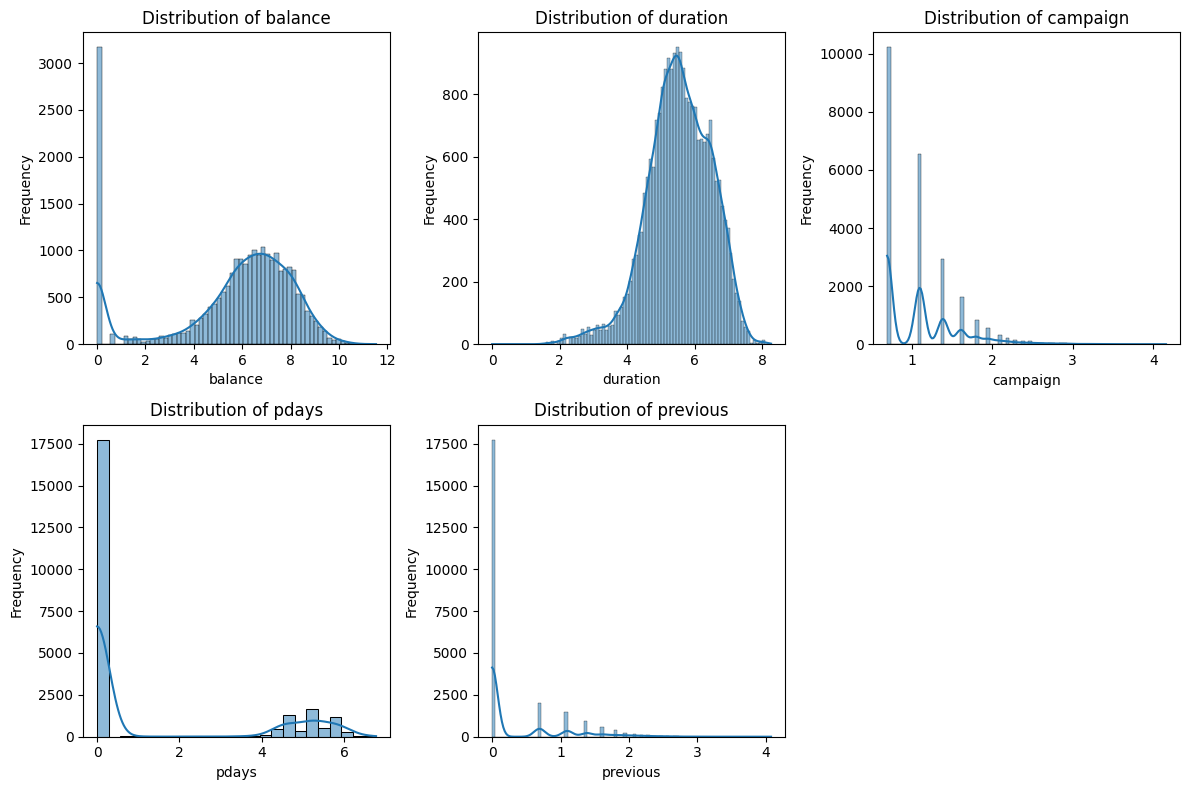

In [ ]:
# 'age'를 제외한 특성들에 대한 히스토그램 그리기
plt.figure(figsize=(12, 8))
for i, feature in enumerate(int_features_without_age, 1):
    plt.subplot(2, 3, i)  # 2x3 subplot에 그리기
    sns.histplot(X_sampled[feature], kde=True)  # 히스토그램과 커널 밀도 추정선(kde) 추가
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 데이터 전처리 - 범주형 및 binary 특성 처리

1. job의 경우 :  10개 종류의 직업으로 분류되기에 one-hot encoding이 적절한 선택이다.
2. martial의 경우 : 마찬가지로 one-hot encoding
3. enducation의 경우 : 교육 수준에 따라 계층적인 순서가 보이므로, one-hot encoding보다는 학력 순서에 따라 0,1,2,.. 로 매핑하는 것이 좋다고 판단된다.
4. default, housing, loan의 경우 : yes, no에 따라 0과 1로 이진 매핑한다.
5. contact의 경우 :  'cellular','telephone'의 두 종류이므로 0과 1로 매핑한다.
6. poutcome의 경우 : unknown이 너무 많아서 (데이터의 70%가 unknown) 제외하는 것이 좋다고 판단했다.


In [ ]:
# education 열의 고유값과 개수 확인
print(X_sampled['education'].value_counts())

# education 열의 고유값 목록만 확인
print(X_sampled['education'].unique())


education
secondary    11717
tertiary      7999
primary       3227
unknown       1010
Name: count, dtype: int64
['tertiary' 'primary' 'secondary' 'unknown']


In [ ]:
# education 열의 고유값과 개수 확인
print(X_sampled['poutcome'].value_counts())

# education 열의 고유값 목록만 확인
print(X_sampled['poutcome'].unique())


poutcome
unknown    17741
failure     2656
success     2367
other       1189
Name: count, dtype: int64
['unknown' 'success' 'other' 'failure']


In [ ]:
import pandas as pd

# job과 marital: One-hot encoding
X_sampled = pd.get_dummies(X_sampled, columns=['job', 'marital'], prefix=['job', 'marital'])

# education: 순서형 인코딩
education_mapping = {
    'primary': 0,
    'secondary': 1,
    'tertiary': 2,
    'unknown': 0
}
X_sampled['education_encoded'] = X_sampled['education'].map(education_mapping)
X_sampled.drop('education', axis=1, inplace=True)

# default, housing, loan: Binary encoding
binary_features = ['default', 'housing', 'loan']
for feature in binary_features:
    X_sampled[feature] = X_sampled[feature].map({'no': 0, 'yes': 1})

# contact: Binary encoding
contact_mapping = {'cellular': 1, 'telephone': 0, 'unknown' : 1}
X_sampled['contact_encoded'] = X_sampled['contact'].map(contact_mapping)
X_sampled.drop('contact', axis=1, inplace=True)


# age: Binning into categories
age_bins = [0, 20, 30, 40, 50, 60, 70, 100]  # 나이 범위 설정
age_labels = ['<20', '20s', '30s', '40s', '50s', '60s', '70+']  # 범주 레이블
X_sampled['age_binned'] = pd.cut(X_sampled['age'], bins=age_bins, labels=age_labels, right=False)
X_sampled.drop('age',axis=1,inplace=True)

X_sampled.drop('poutcome',axis=1,inplace=True)

X_sampled.drop('month',axis=1,inplace=True)

# 결과 확인
print(X_sampled.head())


   default   balance  housing  loan  day  duration  campaign  pdays  previous  \
0        1  5.869297        1     1   18  4.905275  0.693147    0.0       0.0   
1        0  5.966147        0     0    9  4.691348  1.098612    0.0       0.0   
2        0  5.786897        0     0   12  6.385194  1.098612    0.0       0.0   
3        0  0.000000        0     1   18  5.837730  0.693147    0.0       0.0   
4        0  0.000000        1     0   15  5.147494  2.397895    0.0       0.0   

   job_admin.  ...  job_student  job_technician  job_unemployed  job_unknown  \
0       False  ...        False           False           False        False   
1        True  ...        False           False           False        False   
2       False  ...        False           False           False        False   
3       False  ...        False           False           False        False   
4       False  ...        False           False           False        False   

   marital_divorced  marital_mar

In [ ]:
# 결측값 확인
print(X_sampled.isnull().sum())  # 각 열의 결측값 개수


# 만약 문자열이라면, 이를 수치형으로 변환
X_sampled['age_binned'] = X_sampled['age_binned'].astype('category').cat.codes

# 변환 결과 확인
print(X_sampled['age_binned'].head())

default              0
balance              0
housing              0
loan                 0
day                  0
duration             0
campaign             0
pdays                0
previous             0
job_admin.           0
job_blue-collar      0
job_entrepreneur     0
job_housemaid        0
job_management       0
job_retired          0
job_self-employed    0
job_services         0
job_student          0
job_technician       0
job_unemployed       0
job_unknown          0
marital_divorced     0
marital_married      0
marital_single       0
education_encoded    0
contact_encoded      0
age_binned           0
dtype: int64
0    2
1    4
2    2
3    1
4    2
Name: age_binned, dtype: int8


Feature Correlation Matrix:
                    default   balance   housing      loan       day  duration  \
default            1.000000 -0.196548  0.017929  0.085729  0.004286  0.003217   
balance           -0.196548  1.000000 -0.109601 -0.159418 -0.007294  0.046171   
housing            0.017929 -0.109601  1.000000  0.078690 -0.007565 -0.002444   
loan               0.085729 -0.159418  0.078690  1.000000  0.011851 -0.009313   
day                0.004286 -0.007294 -0.007565  0.011851  1.000000 -0.044637   
duration           0.003217  0.046171 -0.002444 -0.009313 -0.044637  1.000000   
campaign           0.013450 -0.050456  0.013849  0.026380  0.120023 -0.109463   
pdays             -0.047867  0.094752 -0.000779 -0.065288 -0.068309  0.029726   
previous          -0.046287  0.092102 -0.010001 -0.057283 -0.064443  0.029339   
job_admin.        -0.012685 -0.032019  0.055020  0.037925  0.005083 -0.009849   
job_blue-collar    0.025513 -0.051662  0.206192  0.047278 -0.007898 -0.012882   


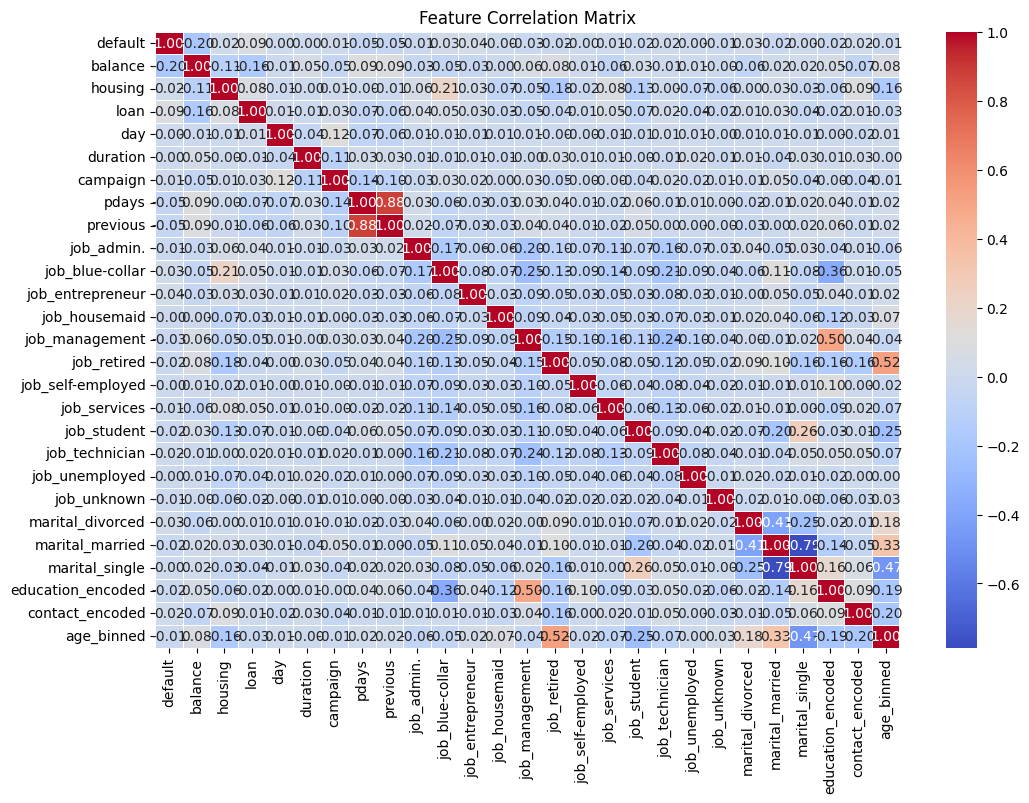

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 특성 간 상관행렬 계산 (수치형 데이터에 대해서만)
correlation_matrix = X_sampled.corr()

# 상관행렬 출력
print("Feature Correlation Matrix:")
print(correlation_matrix)

# 상관행렬 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# X_sampled: 특성(features), y_sampled: 타겟(target) 변수
# 여기서는 'y_sampled'가 타겟 변수로 이미 준비된 상태로 가정합니다.

# Stratified split을 사용하여 70% 학습 데이터, 30% 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.3, random_state=42, stratify=y_sampled
)

# 분할된 데이터 크기 확인
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Training target distribution: {y_train.value_counts()}")
print(f"Test target distribution: {y_test.value_counts()}")


Training data shape: (16767, 27), Test data shape: (7186, 27)
Training target distribution: y
no     8390
yes    8377
Name: count, dtype: int64
Test target distribution: y
no     3596
yes    3590
Name: count, dtype: int64


# 데이터 전처리 결과
총 14개의 feature를 활용하여 기계학습 모델 진행

# 사용 모델 및 지표 선정
* 사용 모델

  기본적인 logistic회귀 모델과 knn 모델,
  svm 모델과 앙상블 모델로 random forest와 XGBoost 모델을 사용할 예정이며 판단
* 지표 선정

  지표는 처음에 언급했던 recall, f1-score, roc-auc를 사용한다.

* 교차 검증 및 하이퍼 파라미터 조정

  grid search cv를 사용하여 교차검증 및 하이퍼 파라미터를 조정한다.


In [ ]:
# 각 컬럼을 순차적으로 float형으로 변환하면서 에러 발생 여부를 확인
for column in X_sampled.columns:
    try:
        # 해당 컬럼을 float로 변환 시도
        X_sampled[column] = X_sampled[column].astype(float)
    except ValueError:
        # 에러 발생 시 컬럼 이름 출력
        print(f"Cannot convert column '{column}' to float")


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import randint

# 모델 정의
dtc = DecisionTreeClassifier(random_state=42)

# 하이퍼파라미터 분포
param_rsv_dtc = {
    'max_depth': randint(1, 20),             # 트리의 최대 깊이
    'min_samples_split': randint(2, 20),     # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': randint(1, 20),      # 리프 노드의 최소 샘플 수
    'criterion': ['gini', 'entropy'],        # 분할 기준
}

# RandomizedSearchCV로 튜닝
rsv_dtc = RandomizedSearchCV(
    estimator=dtc,
    param_distributions=param_rsv_dtc,
    n_iter=50,                   # 탐색할 조합 수
    cv=5,                        # 5-fold 교차 검증
    scoring='roc_auc',           # ROC-AUC 점수 기준
    n_jobs=-1,                   # 모든 CPU 코어 사용
    verbose=1,                   # 진행 상태 출력
    random_state=42              # 재현성을 위한 시드
)

# 모델 학습
rsv_dtc.fit(X_train, y_train)

# 최적 모델
dtc_best = rsv_dtc.best_estimator_

# 예측 및 평가
y_pred = dtc_best.predict(X_test)
y_proba = dtc_best.predict_proba(X_test)[:, 1]  # predict_proba는 확률 값 반환

print("Decision Tree Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Decision Tree Performance:
              precision    recall  f1-score   support

          no       0.83      0.79      0.81      3596
         yes       0.80      0.84      0.82      3590

    accuracy                           0.82      7186
   macro avg       0.82      0.82      0.82      7186
weighted avg       0.82      0.82      0.82      7186

ROC-AUC: 0.89


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score  # 평가 메트릭
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 모델 정의
knn = KNeighborsClassifier()

# 하이퍼파라미터 분포
param_rsv_knn = {
    'n_neighbors': randint(3, 20),  # 이웃 개수: 3부터 20까지 무작위 선택
    'weights': ['uniform', 'distance'],  # 가중치
    'metric': ['euclidean', 'manhattan', 'chebyshev']  # 거리 측정 방법
}

# RandomizedSearchCV로 튜닝
rsv_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_rsv_knn,
    n_iter=50,                   # 탐색할 조합 수
    cv=5,                        # 5-fold 교차 검증
    scoring='roc_auc',           # ROC-AUC 점수 기준
    n_jobs=-1,                   # 모든 CPU 코어 사용
    verbose=1,                   # 진행 상태 출력
    random_state=42              # 재현성을 위한 시드
)

# 모델 학습
rsv_knn.fit(X_train, y_train)

# 최적 모델
knn_best = rsv_knn.best_estimator_

# 예측 및 평가
y_pred = knn_best.predict(X_test)
y_proba = knn_best.predict_proba(X_test)[:, 1]

print("KNN Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
KNN Performance:
              precision    recall  f1-score   support

          no       0.95      0.75      0.84      3596
         yes       0.79      0.96      0.87      3590

    accuracy                           0.85      7186
   macro avg       0.87      0.85      0.85      7186
weighted avg       0.87      0.85      0.85      7186

ROC-AUC: 0.97


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# 로지스틱 회귀 모델 정의
logreg = LogisticRegression(class_weight='balanced', random_state=42)

# 하이퍼파라미터 분포 설정
param_rsv = {
    'C': uniform(0.1, 10),            # 규제 강도: 0.1 ~ 10 사이의 균등 분포
    'max_iter': [500, 1000, 1500],    # 반복 횟수
    'solver': ['lbfgs', 'liblinear']  # 최적화 알고리즘
}

# RandomizedSearchCV 설정
rsv_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_rsv,
    n_iter=50,                        # 탐색할 조합 수
    cv=5,                             # 5-fold 교차 검증
    scoring='f1',                     # F1-score 기준
    verbose=1,                        # 진행 상태 출력
    n_jobs=-1,                        # 모든 CPU 코어 사용
    random_state=42                   # 재현성을 위한 시드
)

# 학습 시작
rsv_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Hyperparameters found:")
print(rsv_search.best_params_)

# 테스트 데이터로 예측
y_pred = rsv_search.best_estimator_.predict(X_test)

# 성능 평가
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Hyperparameters found:
{'C': 3.845401188473625, 'max_iter': 500, 'solver': 'lbfgs'}

Classification Report:
              precision    recall  f1-score   support

          no       0.81      0.77      0.79      3596
         yes       0.78      0.82      0.80      3590

    accuracy                           0.79      7186
   macro avg       0.79      0.79      0.79      7186
weighted avg       0.79      0.79      0.79      7186


Confusion Matrix:
[[2762  834]
 [ 650 2940]]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 모델 정의
gbc = GradientBoostingClassifier(random_state=42)

# 하이퍼파라미터 분포
param_rsv_gbc = {
    'n_estimators': randint(50, 300),       # 50 ~ 300 사이의 랜덤 정수
    'learning_rate': uniform(0.01, 0.3),   # 0.01 ~ 0.3 사이의 균등 분포
    'max_depth': randint(3, 10)            # 3 ~ 10 사이의 랜덤 정수
}

# RandomizedSearchCV 설정
rsv_gbc = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_rsv_gbc,
    n_iter=20,                         # 탐색할 조합 수
    cv=5,                              # 5-fold 교차 검증
    scoring='roc_auc',                 # ROC-AUC 기준
    n_jobs=-1,                         # 모든 CPU 코어 사용
    verbose=1,                         # 진행 상태 출력
    random_state=42                    # 재현성을 위한 랜덤 시드
)

# 학습 시작
rsv_gbc.fit(X_train, y_train)

# 최적 모델
gbc_best = rsv_gbc.best_estimator_

# 예측 및 평가
y_pred = gbc_best.predict(X_test)
y_proba = gbc_best.predict_proba(X_test)[:, 1]

print("Gradient Boosting Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Gradient Boosting Performance:
              precision    recall  f1-score   support

          no       0.94      0.85      0.89      3596
         yes       0.86      0.95      0.90      3590

    accuracy                           0.90      7186
   macro avg       0.90      0.90      0.90      7186
weighted avg       0.90      0.90      0.90      7186

ROC-AUC: 0.96


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 랜덤 포레스트 모델 정의
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 하이퍼파라미터 분포 설정
param_rsv_rf = {
    'n_estimators': randint(50, 300),          # 트리 개수: 50 ~ 300 사이의 랜덤 값
    'max_depth': [None] + list(range(10, 31)), # 최대 깊이: None 또는 10~30 사이
    'min_samples_split': randint(2, 11),       # 최소 분할 샘플 수: 2 ~ 10
    'min_samples_leaf': randint(1, 5),         # 최소 리프 노드 샘플 수: 1 ~ 4
    'max_features': ['sqrt', 'log2']           # 분할 시 고려할 특성 수
}

# RandomizedSearchCV 설정
rsv_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_rsv_rf,
    n_iter=20,                      # 탐색할 하이퍼파라미터 조합 수
    cv=5,                           # 5-fold 교차 검증
    scoring='f1',                   # f1 스코어 기준
    n_jobs=-1,                      # 모든 CPU 코어 사용
    verbose=1,                      # 진행 상황 출력
    random_state=42                 # 재현성을 위한 랜덤 시드
)

# 학습 시작
rsv_rf.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best Hyperparameters found:")
print(rsv_rf.best_params_)

# 테스트 데이터로 예측
y_pred_rf = rsv_rf.predict(X_test)

# 성능 평가
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# 혼동 행렬
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best Hyperparameters found:
{'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 238}

Classification Report:
              precision    recall  f1-score   support

          no       0.89      0.81      0.85      3596
         yes       0.82      0.90      0.86      3590

    accuracy                           0.86      7186
   macro avg       0.86      0.86      0.85      7186
weighted avg       0.86      0.86      0.85      7186


Confusion Matrix:
[[2905  691]
 [ 350 3240]]


# 성능 개선 과정

우선 클래스 yes, no의 비중이 8:1 정도로 차이나는 불균형 클래스여서
그 비율을 유지하는 층화기법을 사용한 랜덤 샘플링을 하였을 때, 랜덤 포레스트의 성능 지표는 다음과 같았다.

Classification Report:
              
              precision    recall  f1-score   support

          no       0.91      0.98      0.94      3952
         yes       0.64      0.26      0.37       524

    accuracy                           0.90      4476



yes class에 대한 recall이 상당히 낮은 것을 볼 수 있는데, 이는 모델이 실제로 yes로 분류해야 할 샘플들을 감지하지 못하는 문제로 볼 수 있다. 그렇기에 처음 샘플링을 진행할 때, yes의 데이터를 더 추가하는 방식으로 데이터를 재샘플링 해보았다.
```from sklearn.model_selection import train_test_split
""" 처음 클래스 불균형을 해소하지 않은 코드
# 'y'가 'yes'와 'no'의 클래스 레이블을 포함한 열이라 가정
X = data.drop('y', axis=1)  # 특성(features) 데이터
y = data['y']  # 타겟 변수(target)

# 층화 샘플링을 통해 33% 샘플링
X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=0.33, stratify=y, random_state=42)

# 결과 확인
print(f"샘플링 후 데이터 크기: {X_sampled.shape}")
print(f"샘플링 후 타겟 분포:\n{y_sampled.value_counts()}")"""


from sklearn.utils import resample
import pandas as pd

# 특성(features) 데이터와 타겟 변수(target)
X = data.drop('y', axis=1)  # 특성(features)
y = data['y']  # 타겟 변수(target)

# 데이터프레임 형태로 병합
df = pd.concat([X, y], axis=1)

# 'yes'와 'no'로 데이터 분리
df_yes = df[df['y'] == 'yes']  # 소수 클래스
df_no = df[df['y'] == 'no']  # 다수 클래스

# 소수 클래스(yes)를 오버샘플링
df_yes_oversampled = resample(
    df_yes,
    replace=True,                # 복원 샘플링
    n_samples=len(df_no),        # 다수 클래스와 같은 크기로 샘플링
    random_state=42              # 재현성을 위한 랜덤 시드
)

# 다수 클래스(no)를 랜덤 언더샘플링 (원래 크기를 유지하려면 이 단계는 생략 가능)
df_no_downsampled = resample(
    df_no,
    replace=False,               # 비복원 샘플링
    n_samples=len(df_yes_oversampled),  # 소수 클래스와 같은 크기로 샘플링
    random_state=42              # 재현성을 위한 랜덤 시드
)

# 오버샘플링된 yes와 다운샘플링된 no를 결합
df_balanced = pd.concat([df_yes_oversampled, df_no_downsampled])

# 섞기(shuffle)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# X와 y로 분리
X_sampled = df_balanced.drop('y', axis=1)
y_sampled = df_balanced['y']

# 결과 확인
print(f"균형 맞춘 데이터 크기: {X_balanced.shape}")
print(f"균형 맞춘 타겟 분포:\n{y_balanced.value_counts()}")


```



그렇게 성능이 급격하게 상승한 것을 볼 수 있다.

Classification Report:

               precision    recall  f1-score   support

          no       0.81      0.78      0.80     11977
         yes       0.79      0.82      0.80     11977

#Feature selection

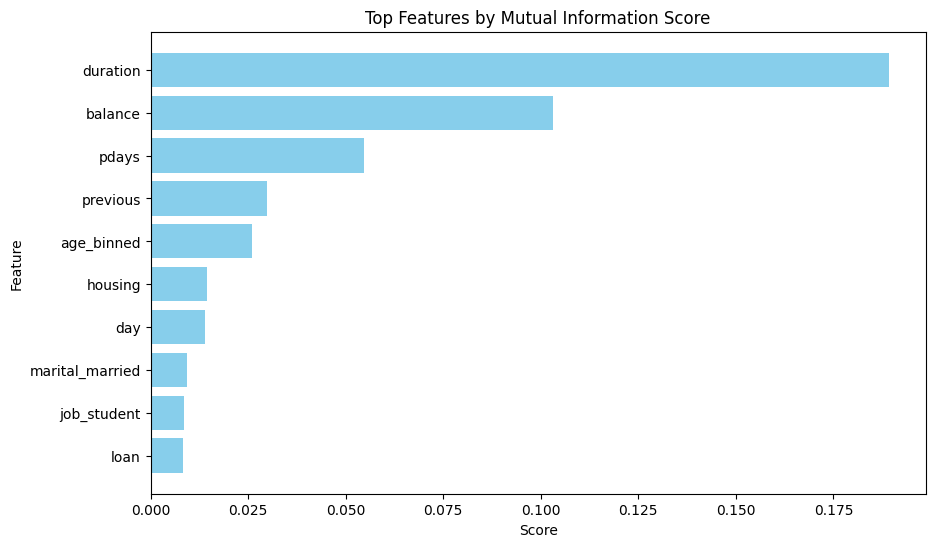

Selected Features (Top 10):
Index(['balance', 'housing', 'loan', 'day', 'duration', 'pdays', 'previous',
       'job_student', 'marital_married', 'age_binned'],
      dtype='object')


In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt

# SelectKBest로 상위 특징 선택
k = 10  # 선택할 상위 특징 개수
selector = SelectKBest(mutual_info_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)

# 선택된 특징과 중요도 점수 출력
selected_features = X_train.columns[selector.get_support()]  # 선택된 특징 이름
scores = selector.scores_  # 모든 특징의 중요도 점수

# 중요도 점수를 데이터프레임으로 정리
feature_scores = pd.DataFrame({'Feature': X_train.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# 상위 k개의 특징 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'][:k], feature_scores['Score'][:k], color='skyblue')
plt.gca().invert_yaxis()  # 상위 특징이 위로 오도록 반전
plt.title('Top Features by Mutual Information Score')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

# 선택된 특징 이름 출력
print("Selected Features (Top {}):".format(k))
print(selected_features)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import uniform, randint

# Gradient Boosting 모델 정의
gbc = GradientBoostingClassifier(random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'n_estimators': randint(100, 300),       # 트리 개수
    'learning_rate': uniform(0.01, 0.2),    # 학습률
    'max_depth': randint(3, 10),            # 트리 깊이
    'min_samples_split': randint(2, 20),    # 분할 최소 샘플 수
    'min_samples_leaf': randint(1, 20),     # 리프 노드 최소 샘플 수
}

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=20,                   # 탐색할 조합 수
    cv=5,                        # 5-fold 교차 검증
    scoring='roc_auc',           # ROC-AUC 기준으로 평가
    n_jobs=-1,                   # 모든 CPU 사용
    verbose=1,                   # 진행 상태 출력
    random_state=42              # 재현성을 위한 시드
)

# 선택된 특징 데이터로 모델 학습
random_search.fit(X_train_selected, y_train)

# 최적의 모델 확인
best_gbc = random_search.best_estimator_
print("Best Hyperparameters:")
print(random_search.best_params_)

# 테스트 데이터에서도 상위 특징 선택 적용
X_test_selected = selector.transform(X_test)

# 최적의 모델로 예측
y_pred = best_gbc.predict(X_test_selected)
y_proba = best_gbc.predict_proba(X_test_selected)[:, 1]

# 성능 평가
print("\nGradient Boosting Performance on Test Set:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters:
{'learning_rate': 0.10903538202225403, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 180}

Gradient Boosting Performance on Test Set:
              precision    recall  f1-score   support

          no       0.92      0.83      0.88      3596
         yes       0.85      0.93      0.89      3590

    accuracy                           0.88      7186
   macro avg       0.88      0.88      0.88      7186
weighted avg       0.88      0.88      0.88      7186

ROC-AUC: 0.94


top-10 feature를 filter 기법으로 selection하여 적용하였는데, 오히려 모델 성능이줄어들었다. one-hot encoding으로 선정했던 feature들이 많이 빠져있는데 ,그 이유는 해당 feature는 개별 중요도는 낮아도 서로간의 상호작용이 중요하기 때문이다. 그렇기에 독립적으로 작용하지 않는 feature들이 제외되어, 성능이 조금 낮아졌다고 추측할 수 있다. 그렇기에, feature간의 상호작용을 고려한 wrapper 방식을 사용해서 feature selection 및 모델 학습을 다시 진행해보았다.  

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import uniform
import numpy as np

# 1. Gradient Boosting 모델 정의
gbc = GradientBoostingClassifier(random_state=42)

# 2. RFECV를 사용해 특징 선택
rfecv = RFECV(estimator=gbc, step=1, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
X_train_selected = rfecv.fit_transform(X_train, y_train)

# 선택된 특징 이름 출력
selected_features = X_train.columns[rfecv.support_]
print(f"Selected Features (Total: {len(selected_features)}):")
print(selected_features)

# 3. Gradient Boosting 하이퍼파라미터 랜덤 탐색
param_dist = {
    'n_estimators': [100, 200, 300],       # 트리 개수
    'learning_rate': uniform(0.01, 0.2),  # 학습률
    'max_depth': [3, 5, 7, 9],            # 트리 최대 깊이
    'subsample': uniform(0.7, 0.3),       # 서브샘플 비율
    'min_samples_split': [2, 5, 10]       # 분할 위한 최소 샘플 수
}

rsv_gbc = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=20,                   # 탐색할 조합 수
    cv=5,                        # 5-fold 교차 검증
    scoring='roc_auc',           # ROC-AUC 점수 기준
    n_jobs=-1,                   # 모든 CPU 코어 사용
    verbose=1,                   # 진행 상태 출력
    random_state=42              # 재현성을 위한 시드
)

# 4. 랜덤 탐색 학습
rsv_gbc.fit(X_train_selected, y_train)

# 최적 모델 출력
gbc_best = rsv_gbc.best_estimator_
print("Best Parameters Found:")
print(rsv_gbc.best_params_)

# 5. 테스트 데이터 평가
X_test_selected = rfecv.transform(X_test)  # 선택된 특징만 사용
y_pred = gbc_best.predict(X_test_selected)
y_proba = gbc_best.predict_proba(X_test_selected)[:, 1]

print("\nGradient Boosting Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")


Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Selected Features (Total: 23):
Index(['default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign',
       'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_management', 'job_retired',
       'job_self-employed', 'job_student', 'job_technician', 'job_unknown',
       'marital_married', 'marital_single', 'education_encoded',
       'contact_encoded', 'age_binned'],
      dtype='object')
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters Found:
{'learning_rate': 0.18323522915498705, 'max_depth': 9, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.71692347370813}

Gradient Boosting Performance:
              precision    recall  f1-score   support

          no       0.95      0.85      0.90      3596
         yes       0.86      0.96      0.91      3590

    accu



```
<feature selection 이전 결과 >

Gradient Boosting Performance:
              precision    recall  f1-score   support

          no       0.94      0.85      0.89      3596
         yes       0.86      0.95      0.90      3590

    accuracy                           0.90      7186
   macro avg       0.90      0.90      0.90      7186
weighted avg       0.90      0.90      0.90      7186

ROC-AUC: 0.96

-----------------------------------------------------
<filter 방식 feature selection 결과>
Gradient Boosting Performance on Test Set:
              precision    recall  f1-score   support

          no       0.92      0.83      0.88      3596
         yes       0.85      0.93      0.89      3590

    accuracy                           0.88      7186
   macro avg       0.88      0.88      0.88      7186
weighted avg       0.88      0.88      0.88      7186

ROC-AUC: 0.94
----------------------------------
<"wrapper" 방식 feature selection 결과>
Gradient Boosting Performance:
              precision    recall  f1-score   support

          no       0.95      0.85      0.90      3596
         yes       0.86      0.96      0.91      3590

    accuracy                           0.90      7186
   macro avg       0.91      0.90      0.90      7186
weighted avg       0.91      0.90      0.90      7186

ROC-AUC: 0.96

```
wrapper 방식으로 한 것이 성능 향상에 도움이 되었음을 확인할 수 있다.
wrapper 방식은 feature 간의 상호작용을 반영하는 방식이므로, 더욱 모델에 최적화된 성능 향상을 이끌어 낼 수 있기 때문이다.





최종적으로 다음과 같은 feature와, 모델 및 하이퍼 파라미터 최적화를 얻을 수 있다.


```
1. Gradient boosting model

2. Selected Features (Total: 23):
  Index(['default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign',
       'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_management', 'job_retired',
       'job_self-employed', 'job_student', 'job_technician', 'job_unknown',
       'marital_married', 'marital_single', 'education_encoded',
       'contact_encoded', 'age_binned'],
      dtype='object')
      
3. Best Parameters Found:
  {'learning_rate': 0.18323522915498705, 'max_depth': 9, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.71692347370813}
```

